<a href="https://colab.research.google.com/github/MoltenMuffins/MagicSchoolBus/blob/master/MagicSepCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Thank you https://developers.google.com/machine-learning/guides/text-classification/step-4

## 2. Explore Data

In [0]:
#Download the files from the Kaggle NSDC page
!wget -qq https://www.dropbox.com/s/dlpf8lirpf69nvb/ndsc-beginner.zip

#Unzip the zip file
!unzip -qq -n ndsc-beginner.zip

#Remove zipfile, we won't need it anymore
!rm ndsc-beginner.zip

#Check directory contents
!ls

#The files we want are all in the folder ndsc-beginner

 google_ndsc_sepcnn_wbatchnorm.csv   sample_data
 keras-adabound			     tzuchieh_sepcnn_batchnorm
 __MACOSX			    'yuning_sepcnn(1)_wbatchnorm_model.h5'
 ndsc-beginner


In [0]:
import pandas as pd

In [0]:
train_df = pd.read_csv("./ndsc-beginner/train.csv")
train_df.head()

,itemid,title,Category,image_path
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg


In [0]:
train_df.shape

(666615, 4)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
train_texts = train_df['title'].tolist()
train_labels = np.array(train_df['Category'].tolist())

In [0]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
    
def get_max_words_all_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.max(num_words)

In [0]:
get_num_words_per_sample(train_texts)

9.0

In [0]:
get_max_words_all_sample(train_texts)

32

In [0]:
666615/9

74068.33333333333

## 2.5 Choose Model

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):
  * Split the samples into word n-grams; convert the n-grams into vectors.
  * Score the importance of the vectors and then select the top 20K using the scores.
  * Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):   
   * Split the samples into words; select the top 20K words based on their frequency.
   * Convert the samples into word sequence vectors.
   * If the original number of samples/number of words per sample ratio is less than 15K, using a fine-tuned pre-trained embedding with the sepCNN model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [0]:
#Calculate samples divided (by number of words per sample)
ratio = len(train_texts)/get_num_words_per_sample(train_texts)

if ratio < 1500:
  print('Use an MLP model')
elif ratio > 1500:
  print('Use sepCNN')

Use sepCNN


![alt text](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png =550x)

For the rest of this notebook we shall use the instructions contained in (Option B) to build our model.

## 3. Prepare 

Before our data can be fed to a model, it needs to be transformed to a format the model can understand.

First, the data samples that we have gathered may be in a specific order. We do not want any information associated with the ordering of samples to influence the relationship between texts and labels. For example, if a dataset is sorted by class and is then split into training/validation sets, these sets will not be representative of the overall distribution of data.

A simple best practice to ensure the model is not affected by data order is to always shuffle the data before doing anything else. If your data is already split into training and validation sets, make sure to transform your validation data the same way you transform your training data. If you don’t already have separate training and validation sets, you can split the samples after shuffling; it’s typical to use 80% of the samples for training and 20% for validation.

Second, machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

**Tokenization:** Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).

**Vectorization:** Define a good numerical measure to characterize these texts.

In [0]:
#Generate Sequence Vectors
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500
max_length = 30

def train_tokenizer(train_texts):
    # Create vocabulary with training texts.
    global tokenizer
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

def sequence_vectorize(train_texts, val_texts, max_length):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
#     max_length = len(max(x_train, key=len))
#     if max_length > MAX_SEQUENCE_LENGTH:
#         max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [0]:
datasetlen = len(train_texts)
train_df = train_df.sample(frac=1) #Shuffle rows

a_df = train_df[:int(datasetlen*0.8)]
b_df = train_df[int(datasetlen*0.2):]

train_texts = a_df['title'].tolist()
val_texts = b_df['title'].tolist()

**Label vectorization**

We saw how to convert sample text data into numerical vectors. A similar process must be applied to the labels. We can simply convert labels into values in range [0, num_classes - 1]. For example, if there are 3 classes we can just use values 0, 1 and 2 to represent them. Internally, the network will use one-hot vectors to represent these values (to avoid inferring an incorrect relationship between labels). This representation depends on the loss function and the last- layer activation function we use in our neural network. We will learn more about these in the next section.

In [0]:
#No need to do this since our data is already in the form of numerical vectors
train_labels = np.array(a_df['Category'].tolist())
val_labels = np.array(b_df['Category'].tolist())

## 4. Build, Train, and Evaluate Your Model

In [0]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

**LOAD_GLOVE_EMBEDDINGS** 

---



In [0]:
import numpy as np


def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [0]:
#The following code constructs a four-layer sepCNN model:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Activation
from tensorflow import keras

#from google.colab import drive
#drive.mount('/gdrive')

# import glove embeddings

#word2index, embedding_matrix = load_glove_embeddings('/gdrive/My Drive/Copy of NDSC_Free_100d.txt', embedding_dim=100)
# End import


# from tensorflow.python.keras.layers import Bidirectional, CuDNNGRU

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            input_length=max_length,
                            weights=[embedding_matrix],
                            trainable=False))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))
    if blocks >= 1:
      for _ in range(blocks-1):
         # Model depth changes with var blocks
          model.add(Dropout(rate=dropout_rate))
          model.add(SeparableConv1D(filters=filters,
                                    kernel_size=kernel_size,
                                    activation='relu',
                                    bias_initializer='random_uniform',
                                    depthwise_initializer='random_uniform',
                                    padding='same'))
          model.add(SeparableConv1D(filters=filters,
                                    kernel_size=kernel_size,
                                    activation='relu',
                                    bias_initializer='random_uniform',
                                    depthwise_initializer='random_uniform',
                                    padding='same'))
          model.add(MaxPooling1D(pool_size=pool_size))

      model.add(SeparableConv1D(filters=filters * 2,
                                kernel_size=kernel_size,
  #                               activation='relu',
                                bias_initializer='random_uniform',
                                depthwise_initializer='random_uniform',
                                kernel_regularizer=keras.regularizers.l2(0.001),
                                padding='same'))
      model.add(BatchNormalization())
      model.add(Activation('relu'))
      model.add(SeparableConv1D(filters=filters * 2,
                                kernel_size=kernel_size,
  #                               activation='relu',
                                bias_initializer='random_uniform',
                                depthwise_initializer='random_uniform',
                                kernel_regularizer=keras.regularizers.l2(0.001),
                                padding='same'))
      model.add(BatchNormalization())
      model.add(Activation('relu'))
      model.add(GlobalAveragePooling1D())
      model.add(Dropout(rate=dropout_rate))
      model.add(Dense(op_units, activation=op_activation))
    
    # Enable blocks = 0.5
    elif blocks == 0.5:
      model.add(SeparableConv1D(filters=filters * 2,
                                kernel_size=kernel_size,
  #                               activation='relu',
                                bias_initializer='random_uniform',
                                depthwise_initializer='random_uniform',
                                kernel_regularizer=keras.regularizers.l2(0.001),
                                padding='same'))
      model.add(BatchNormalization())
      model.add(Activation('relu'))
      model.add(GlobalAveragePooling1D())
      model.add(Dropout(rate=dropout_rate))
      model.add(Dense(op_units, activation=op_activation))
      
    return model

## 4.5 Train Model

In [0]:
import os

def _load_and_shuffle_data(data_path,
                           file_name,
                           seed):
    """Loads and shuffles the dataset using pandas.
    # Arguments
        data_path: string, path to the data directory.
        file_name: string, name of the data file.
        cols: list, columns to load from the data file.
        seed: int, seed for randomizer.
        separator: string, separator to use for splitting data.
        header: int, row to use as data header.
    """
    np.random.seed(seed)
    data_path = os.path.join(data_path, file_name)
    data = pd.read_csv(data_path)
    return data.reindex(np.random.permutation(data.index))

def _split_training_and_validation_sets(texts, labels, validation_split):
    """Splits the texts and labels into training and validation sets.
    # Arguments
        texts: list, text data.
        labels: list, label data.
        validation_split: float, percentage of data to use for validation.
    # Returns
        A tuple of training and validation data.
    """
    num_training_samples = int((1 - validation_split) * len(texts))
    return ((texts[:num_training_samples], labels[:num_training_samples]),
            (texts[num_training_samples:], labels[num_training_samples:]))  
  
# Replaces load_data and loads our title data instead.

def load_nsdc_dataset(data_path, validation_split=0.2, seed=123):
    """Loads the shopee nsdc basic classification challenge dataset.
    # Arguments
        data_path: string, path to the data directory.
        validation_split: float, percentage of data to use for validation.
        seed: int, seed for randomizer.
    # Returns
        A tuple of training and validation data.
        Number of training samples: 124848
        Number of test samples: 31212
        Number of categories: 5 (0 - negative, 1 - somewhat negative,
                2 - neutral, 3 - somewhat positive, 4 - positive)
    """
    columns = (1, 2)  # 2 - Phrases, 3 - Sentiment.
    data = _load_and_shuffle_data(data_path, 'train.csv', seed)

    # Get the review phrase and sentiment values.
    texts = list(data['title'])
    labels = np.array(data['Category'])
    return _split_training_and_validation_sets(texts, labels, validation_split)


In [0]:
data_path = './ndsc-beginner/'
data = load_nsdc_dataset(data_path, validation_split=0.2, seed=123)
test_df = pd.read_csv("./ndsc-beginner/test.csv") 
test_texts = list(test_df['title'])

# Adjust Hyperparameter Values Here

In [0]:
# Limit on the number of words to considered for word vectorization
TOP_K = 10000

#Hyperparams
learning_rate=5e-1
#This is the minimum learn rate value allowed despite ReduceLearningRateonPlateau
min_lr = 0.0000001
lr_factor = 0.2
patience = 5

epochs=40
batch_size=64
blocks=1
filters=128
dropout_rate=0.3
embedding_dim=100
kernel_size=9
pool_size=3

In [0]:
"""
Vectorizes training and validation texts into sequences and uses that for
training a sequence model - a sepCNN model. We use sequence model for text
classification when the ratio of number of samples to number of words per
sample for the given dataset is very large (>~15K).
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import time

import tensorflow as tf
import numpy as np

# import build_model
# import load_data
# import vectorize_data
# import explore_data

FLAGS = None

"""Trains sequence model on the given dataset.
# Arguments
    data: tuples of training and test texts and labels.
    learning_rate: float, learning rate for training model.
    epochs: int, number of epochs.
    batch_size: int, number of samples per batch.
    blocks: int, number of pairs of sepCNN and pooling blocks in the model.
    filters: int, output dimension of sepCNN layers in the model.
    dropout_rate: float: percentage of input to drop at Dropout layers.
    embedding_dim: int, dimension of the embedding vectors.
    kernel_size: int, length of the convolution window.
    pool_size: int, factor by which to downscale input at MaxPooling layer.
# Raises
    ValueError: If validation data has label values which were not seen
        in the training data.
"""
# Get the data.
(train_texts, train_labels), (val_texts, val_labels) = data

# Verify that validation labels are in the same range as training labels.
# num_classes = explore_data.get_num_classes(train_labels)
num_classes = 58
unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
if len(unexpected_labels):
    raise ValueError('Unexpected label values found in the validation set:'
                     ' {unexpected_labels}. Please make sure that the '
                     'labels in the validation set are in the same range '
                     'as training labels.'.format(
                         unexpected_labels=unexpected_labels))

# Vectorize texts.
#   x_train, x_val, word_index = vectorize_data.sequence_vectorize(
#           train_texts, val_texts)
all_texts = train_texts + test_texts
print(all_texts[0:9])
train_tokenizer(all_texts)
x_train, x_val, word_index = sequence_vectorize(train_texts, val_texts, 30)

# Number of features will be the embedding input dimension. Add 1 for the
# reserved index 0.
num_features = min(len(word_index) + 1, TOP_K)
print('num_features:{}'.format(num_features))

['osella off shoulder stripe brand matahari', 'wanita mini dress segar print o neck lengan pendek kasual longgar gadis summer', '5 g natural mica powder', 'ysl le cushion engraved name', 'make over camuflage cream face concealer', 'terbatas ultima ii wonderwear stay last liquid make up foundation', 'bestseller wet n and wild photofocus photo focus foundation peach natural', 'bedak ertos baked powder all in 1', 'makeup base liquid foundation longlasting waterproof moisturizer oil control']
num_features:10000


In [0]:
!git clone https://github.com/titu1994/keras-adabound.git

fatal: destination path 'keras-adabound' already exists and is not an empty directory.


In [0]:
model = sepcnn_model(blocks=blocks,
                     filters=filters,
                     kernel_size=kernel_size,
                     embedding_dim=embedding_dim,
                     dropout_rate=dropout_rate,
                     pool_size=pool_size,
                     input_shape=x_train.shape[1:],
                     num_classes=num_classes,
                     num_features=num_features)

# optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1000000   
_________________________________________________________________
separable_conv1d (SeparableC (None, 30, 256)           26756     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 30, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 30, 256)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 30, 256)           68096     
_________________________________________________________________
batch_normalization_v

In [0]:
from tensorflow.keras.callbacks import *
#Callbacks ring ring
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=lr_factor,
                              patience=patience,
                              verbose = 1,
                              min_lr=min_lr)

checkpoint = ModelCheckpoint('sepcnn_batchnorm', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)


In [0]:
# Train and validate model.
history = model.fit(
        x_train,
        train_labels,
        epochs=epochs,
        validation_data=(x_val, val_labels),
        verbose=1,
        batch_size=batch_size,
        callbacks=[reduce_lr, checkpoint])


Train on 533292 samples, validate on 133323 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
533248/533292 [============================>.] - ETA: 0s - loss: 1.1313 - acc: 0.6629
Epoch 00001: val_acc improved from -inf to 0.69788, saving model to tzuchieh_sepcnn_batchnorm
533292/533292 [==============================] - 98s 183us/sample - loss: 1.1312 - acc: 0.6629 - val_loss: 0.9721 - val_acc: 0.6979
Epoch 2/40
533184/533292 [============================>.] - ETA: 0s - loss: 0.9642 - acc: 0.7009
Epoch 00002: val_acc improved from 0.69788 to 0.70862, saving model to tzuchieh_sepcnn_batchnorm
533292/533292 [==============================] - 97s 182us/sample - loss: 0.9641 - acc: 0.7009 - val_loss: 0.9252 - val_acc: 0.7086
Epoch 3/40
532992/533292 [============================>.] - ETA: 0s - loss: 0.9215 - acc: 0.7099
Epoch 00003: val_acc improved from 0.70862 to 0.71090, saving model to tzuchieh_sepcnn_batchnorm
533292/533292 [==============================] - 96s 180u

After running the model for some time, look through the epochs and identify the epoch with the best validation_accuracy. Copy and paste the epoch line into the google sheet. Thanks!

In [0]:
# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Validation accuracy: 0.7381697297096252, loss: 0.9169268518741954


In [0]:
# If the model is good, save the model to file, then download it!
model.save('sepcnn_wbatchnorm_model.h5')
# return history['val_acc'][-1], history['val_loss'][-1]

In [0]:
# from sklearn.linear_model import LogisticRegression

# classifier = LogisticRegression()
# classifier.fit(x_train, train_labels)
# score = classifier.score(x_val, val_labels)

# print("Accuracy:", score)

In [0]:
model.save('my_model.h5')

## Make Inferences

With the model fit, we can now use it to make inferences on our actual test data which we do not have labels for.

We then save the predicted classes for each title in csv format.

In [0]:
#We can ignore x_trash
x_test, x_trash, word_index = sequence_vectorize(test_df['title'], ['hi']*len(test_df['title']), 30)

In [0]:
print(x_test[1:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  129  344  314  287  147  371   29    3
    61  627]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   26  237 1711   77  432  619   29    3 2356
   122 1285]]


In [0]:
test_preds = model.predict(x_test)
yeet = [np.argmax(pred) for pred in test_preds]

submit_df = pd.DataFrame({"itemid": test_df["itemid"], "Category": yeet})
submit_df.to_csv("google_ndsc_sepcnn_wbatchnorm.csv", index=False)

In [0]:
print(submit_df.head())

   Category      itemid
0         5   370855998
1         5   637234604
2         5   690282890
3         5   930913462
4         5  1039280071


## Look at Predictions/Data

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[210, 598, 300, 1919, 1840, 2193, 11, 304, 87, 152, 15, 28, 55208, 6431, 3759, 683, 2790, 189, 2692, 128, 321, 118, 213, 13, 97, 19051, 20276, 6963, 3161, 2020, 209, 7173, 7857, 1289, 3753, 5985, 277, 614, 1332, 195, 109, 5147, 2966, 1747, 254, 540, 210, 230, 134, 130, 69, 137, 23, 97, 79, 35, 29, 12]
[3017, 22880, 9252, 64782, 34211, 44221, 1619, 9304, 4884, 6446, 851, 3296, 17335, 2399, 2155, 482, 1771, 2206, 45211, 10834, 15889, 8414, 12269, 1330, 3404, 27298, 27234, 12949, 5200, 2673, 1148, 22174, 23800, 3879, 11731, 24512, 827, 1812, 3784, 555, 263, 15541, 8393, 4937, 757, 1742, 549, 753, 326, 463, 227, 308, 100, 340, 248, 123, 145, 39]


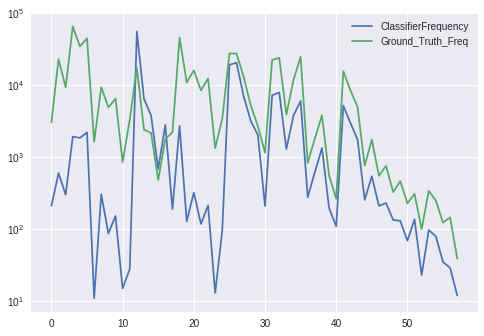

In [0]:
from collections import Counter
x = list(range(0, 58))
print(x)

#Spaghetti Line (aglio olio flavored)
ClassifierFrequency = [x[1] for x in np.array(sorted(Counter(yeet).items()))]
#Haxx cause our classifier didn't predict a class 57
# ClassifierFrequency.append(-1)
print(ClassifierFrequency)

#Also plot frequency of each cat meow (this is bolognese)
Ground_Truth_Freq = [x[1] for x in sorted(Counter(train_labels.tolist()).items())]

print(Ground_Truth_Freq)

#Plot em
plt.plot(x,ClassifierFrequency,Ground_Truth_Freq)
#Add Legend
plt.gca().legend(('ClassifierFrequency','Ground_Truth_Freq'))
plt.yscale("log")

#Show em
plt.show()

#Save a this plot for future reference and comparison
#Right Click > Save Image As...
#Change filename to biLSTMbal01

## 5: Tune Hyperparameters
We had to choose a number of hyperparameters for defining and training the model. We relied on intuition, examples and best practice recommendations. Our first choice of hyperparameter values, however, may not yield the best results. It only gives us a good starting point for training. Every problem is different and tuning these hyperparameters will help refine our model to better represent the particularities of the problem at hand. Let’s take a look at some of the hyperparameters we used and what it means to tune them:

### Number of layers in the model: 
The number of layers in a neural network is an indicator of its complexity. We must be careful in choosing this value. Too many layers will allow the model to learn too much information about the training data, causing overfitting. Too few layers can limit the model’s learning ability, causing underfitting. For text classification datasets, we experimented with one, two, and three-layer MLPs. Models with two layers performed well, and in some cases better than three-layer models. Similarly, we tried sepCNNs with four and six layers, and the four-layer models performed well.

### Number of units per layer:
The units in a layer must hold the information for the transformation that a layer performs. For the first layer, this is driven by the number of features. In subsequent layers, the number of units depends on the choice of expanding or contracting the representation from the previous layer. Try to minimize the information loss between layers. We tried unit values in the range [8, 16, 32, 64], and 32/64 units worked well.

### Dropout rate:
Dropout layers are used in the model for regularization. They define the fraction of input to drop as a precaution for overfitting. Recommended range: 0.2–0.5.

### Learning rate:
This is the rate at which the neural network weights change between iterations. A large learning rate may cause large swings in the weights, and we may never find their optimal values. A low learning rate is good, but the model will take more iterations to converge. It is a good idea to start low, say at 1e-4. If the training is very slow, increase this value. If your model is not learning, try decreasing learning rate.

There are couple of additional hyperparameters we tuned that are specific to our sepCNN model:

### Kernel size:
The size of the convolution window. Recommended values: 3 or 5.

### Embedding dimensions:
The number of dimensions we want to use to represent word embeddings—i.e., the size of each word vector. Recommended values: 50–300. In our experiments, we used GloVe embeddings with 200 dimensions with a pre- trained embedding layer.


```
Play around with these hyperparameters and see what works best. Once you have chosen the best-performing hyperparameters for your use case, your model is ready to be deployed.
```

Refer to [the tutorial](https://github.com/google/eng-edu/tree/master/ml/guides/text_classification) for instructions on how to build additional parts of the model